In [1]:
import cv2
import mediapipe as mp
import time
import numpy as np
# import numpy as np
import random
from tqdm import tqdm
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt 
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from tensorflow.keras.callbacks import *
from keras.layers.convolutional import *
import tensorflow as tf

In [13]:
import csv
import numpy as np

In [28]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 20 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_num = 20 # 21 class with no action
        self.feat_d = 190
        self.filters = 64
        self.nd = 60
C = Config()

In [251]:

 
p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
p.shape

(16, 20, 3)

In [29]:
def zoom(p,target_l=32,joints_num=20,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim]) 
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]         
    return p_new

def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)   
    return M

def norm_train(p):
    # normolize to start point, use the center for hand case
    # p[:,:,0] = p[:,:,0]-p[:,3:4,0]
    # p[:,:,1] = p[:,:,1]-p[:,3:4,1]
    # p[:,:,2] = p[:,:,2]-p[:,3:4,2]
    # # return p
       
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p
def norm_train2d(p):
    # normolize to start point, use the center for hand case
    # p[:,:,0] = p[:,:,0]-p[:,3:4,0]
    # p[:,:,1] = p[:,:,1]-p[:,3:4,1]
    # p[:,:,2] = p[:,:,2]-p[:,3:4,2]
    # # return p
       
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    # p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p
# def normlize_test(p):
#     # normolize to start point, use the center for hand case
#     p[:,:,0] = p[:,:,0]-p[:,1:2,0]
#     p[:,:,1] = p[:,:,1]-p[:,1:2,1]
#     p[:,:,2] = p[:,:,2]-p[:,1:2,2]
#     # p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
#     # p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
#     # p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
#     return p
#     return p

In [30]:
drop_rate = 0.1
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x
def poses_diff_2(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    # x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x
def pose_motion_2(D, frame_l):
    x_1 = Lambda(lambda x: poses_diff_2(x))(D)
    x_1 = Reshape((frame_l,-1))(x_1)
    return x_1

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    x_1 = Reshape((frame_l,-1))(P)
    return P_diff_slow,P_diff_fast
# def reshape_x_2(D, frame_l):
#     x_1 = Lambda(lambda y: poses_diff_2(y))(D)
#     x_1 = Reshape((frame_l, -1))(D)

def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=20,joint_d=3,feat_d=190,filters=16, nd=60):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    # D = Input(shape =(frame_l, joint_n, joint_d))
    # x_ = pose_motion_2(D, frame_l)
    diff_slow,diff_fast = pose_motion(P,frame_l)
    


    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(drop_rate)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(drop_rate)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(drop_rate)(x)

    
    # x_1 = c1D(x_1, filters*2,1)
    # x_1 = SpatialDropout1D(drop_rate)(x_1)
    # x_1 = c1D(x_1, filters, 3)
    # x_1 = SpatialDropout1D(drop_rate)(x_1)
    # x_1 = c1D(x_1, filters,1)
    # x_1 = MaxPooling1D(2)(x_1)
    # x_1 = SpatialDropout1D(drop_rate)(x_1)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(drop_rate)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(drop_rate)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(drop_rate)(x_d_slow)

    # x = c1D(diff_fast,filters*2,1)
    # x = SpatialDropout1D(drop_rate)(x)
    # x = c1D(x,filters,3) 
    # x = SpatialDropout1D(drop_rate)(x)
    # x = c1D(x,filters,1) 
    # x = SpatialDropout1D(drop_rate)(x)

    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(drop_rate)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(drop_rate)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(drop_rate)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(drop_rate)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(drop_rate)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(drop_rate)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    # D = Input(name ='D', shape =(C.frame_l, C.joint_n,C.joint_d))
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(20, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [31]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 190)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 20, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 4, 512)       1733376     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 512)          0           model[0][0]                

In [32]:
DD_Net.load_weights('/home/giang/Downloads/gg1.h5')

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
joint_orders_kinect = [[0,1], [1,2], [2,3], [2,4], [2,8], [4,5], [5,6], [6,7], [8,9], [9,10], [10,11], 
                 [0,12], [0,16], [12,13], [13,14], [14,15], [16,17], [17,18], [18,19]]
joint_orders_mp = [[0, 1], [1, 2], [2, 3], [3, 7], [0, 4], [4, 5], [5, 6], [6, 8], [9, 10], [11, 12], [12, 14], [14, 16],
                 [16, 22], [16, 18], [16, 20], [18, 20], [11, 13], [13, 15], [15, 21], [15, 17], [15, 19], [17, 19], [12, 24],
                 [24, 26], [26, 28], [28, 30], [28, 32], [30, 32], [11, 23], [23, 25], [25, 27], [27, 29], [27, 31], [29, 31],
                 [23, 24]]

def kinect2mp_spec_joint(mp, joint1, joint2):
    kinect = np.zeros(3, dtype=np.float32)
    kinect[0] = (mp[joint1][0] + mp[joint2][0]) / 2
    kinect[1] = (mp[joint1][1] + mp[joint2][1]) / 2
    kinect[2] = (mp[joint1][2] + mp[joint2][2]) / 2
    return kinect

def mp2kinect(mp):
    kinect2mp_list = [[3,0], [4,11], [5,13], [6,15], [8,12], [9,14], [10,16], [12,23],
    [13,25], [14,27], [15,31], [16,24], [17,26], [18,28], [19,32]]
    kinect = np.zeros((20,3), dtype=np.float32)
    for jointID in kinect2mp_list:
        kinect[jointID[0]] = mp[jointID[1]]
    kinect[0] = kinect2mp_spec_joint(mp, 23, 24)
    kinect[2] = kinect2mp_spec_joint(mp, 11, 12)
    kinect[1] = kinect2mp_spec_joint(kinect, 0, 2)
    kinect[11] = kinect2mp_spec_joint(mp, 18, 20)
    kinect[7] = kinect2mp_spec_joint(mp, 17, 19)
    return kinect
    return kinect
def visualize(skeleton_data, joint_orders):
    x = []
    y = []
    plt.axis('equal')
    for coord in skeleton_data:
        coord = list(map(float, coord))
        x.append(coord[0])
        y.append(coord[1])
    plt.scatter(x, y, color = "green")
    for joint_order in joint_orders:
        x_coord = [x[joint_order[0]], x[joint_order[1]]]
        y_coord = [y[joint_order[0]], y[joint_order[1]]]
        plt.plot(x_coord, y_coord, color=plt.cm.gray(0))


In [3]:
subject_test = [1,2,4,5,7,8]

In [81]:
for i in os.listdir(path):
    f_name = f'{i}'
    subject = int(f_name[5:7])
    
    if subject in subject_test:
        file_src = os.path.join(path,i)
        file_dst = os.path.join (path_dst , i)
        
        shutil.move(file_src , file_dst)
        
        
        

                         
    


In [59]:
import shutil
folder1 = '/home/giang/Downloads/MICA_Action3d/train'
folder2 = '/home/giang/Downloads/MICA_Action3d/folder2/a01_s01_e01_skeleton3D.txt'



In [4]:
import pickle


In [9]:
import pickle
Train = pickle.load(open("/home/giang/Downloads/MICA_Action3d/traintrainMICA.pkl", "rb"))
Test = pickle.load(open("/home/giang/Downloads/MICA_Action3d/testtestMICA.pkl", "rb"))

In [3]:
set(Test['label'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [95]:
count = 0
for  index, data in enumerate(Train['pose']):
    if data.shape[0] < 20:
        count = count + 1
        print(index)

print(count)



0


In [25]:
from statistics import mean
a = [1,2,3,4]
mean(a)

2.5

In [12]:
a = []
for  index, data in enumerate(act_train['label']):
    if data == 11:
        print(index)



15
16
17
18
216
217
218
219
287
288
289
290
291
292
312
313
314
320
321
322
323
398
399
400
401
402
786
787
788
844
845
846
951
952
953
954
967
968
969
970
1160
1161
1272
1273
1274
1275
1276
1277
1329
1330
1331
1351
1352
1353
1354
1355
1381
1382
1383
1384
1385
1458
1459
1460
1461
1490
1491
1659
1809
1810
1811
1825
1826
1827
1828
1862
1863
1864
1865
1866
1867
2115
2116
2117
2118
2119
2159
2160
2161
2162
2171
2276
2277
2278
2299
2300
2301
2326
2327
2328
2329
2393
2394
2459
2460
2461
2539
2540
2541
2542
2543
2725
2726
2727
2834
2835
2848
2849
2850
2851
2990
2991
2992
3000
3001
3002
3112
3113
3114
3115
3116
3181
3182
3301
3302
3303
3304
3472
3473
3474
3475
3476
3477
3611
3612
3613
3867
3868
3869
3870


In [13]:
i = 15

a = act_train['pose'][i].reshape(-1,20,3)
print(a.shape)
print(act_train['label'][i])


(32, 20, 3)
11


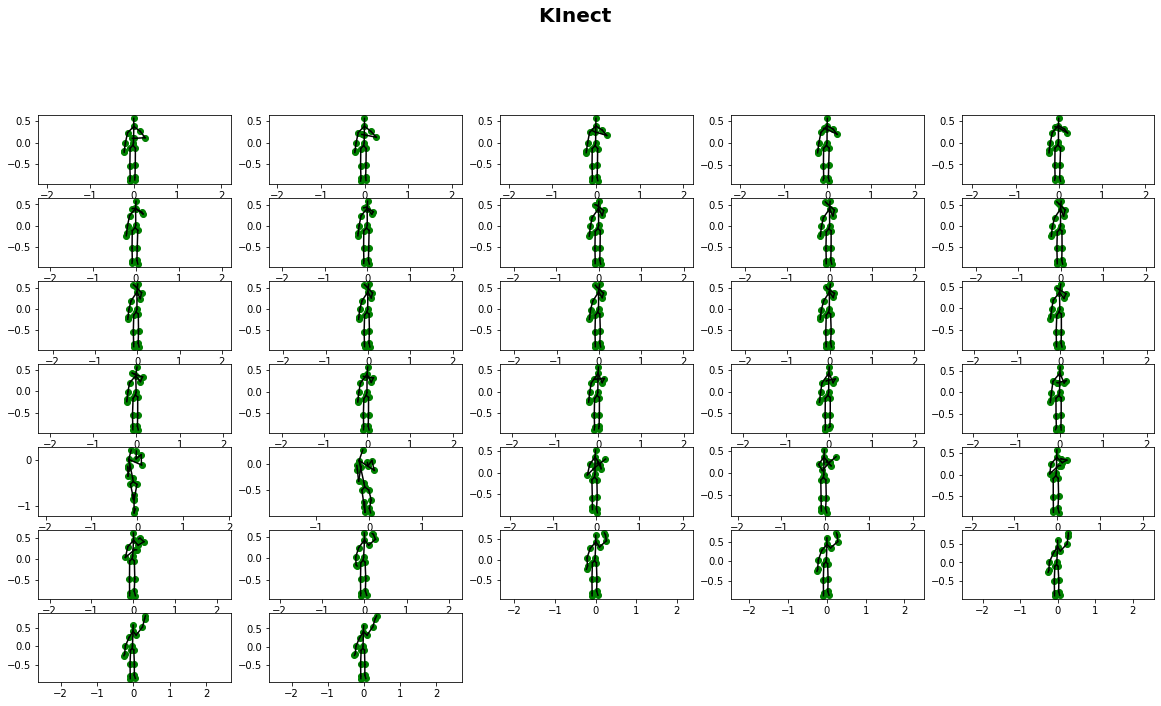

In [27]:
fig = plt.figure(figsize=(20, 15))
fig.suptitle('KInect ', fontsize=20, fontweight='bold')
# setting values to rows and column variables
rows = 10
columns = 5 

for i in range(32):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(a[i], joint_orders_mp) 

In [6]:
i = 53

a = Train['pose'][i].reshape(-1,20,3)
print(a.shape)
print(Train['label'][i])

(88, 20, 3)
1


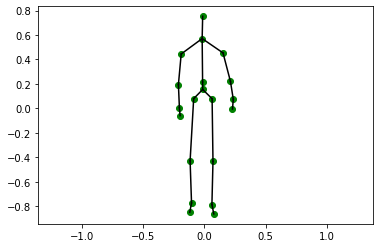

In [7]:
visualize(a[0], joint_orders_kinect) 

In [14]:
for  index, data in enumerate(ac['label']):
    if data == 5 :
        print(index)
        

18
31
46
73
81
86
125
139
144
228
239
244
273
276
284
289
304
349


In [7]:
act_train ={}
act_train['pose'] =[]
act_train['label'] =[]
act_test ={}
act_test['pose'] =[]
act_test['label'] =[]

In [53]:
for i in range(4, 36 -31, 6):
    print(i)

4


In [16]:
list_draw = [7,8,9,15]
list_modified = [1,2,3,4,5,6]

In [10]:

for index, data in enumerate(Train['pose']):
    if data.shape[0] < 40:
        act_train['pose'].append(data)
        act_train['label'].append(Train['label'][index])
    else:
        
            
        for i in range (0, data.shape[0] - 32, 6):
            act_train['pose'].append(data[i:i+32])
            act_train['label'].append(Train['label'][index])
                

            

In [18]:
for 

0
6


In [11]:
print(len(act_train['pose']))
print(len(act_train['label']))
print(len(act_test['pose']))
print(len(act_test['label']))

3958
3958
0
0


In [99]:

for index, data in enumerate(Test['pose']):
    if data.shape[0] < 40:
        act_test['pose'].append(data)
        act_test['label'].append(Test['label'][index])
    else:
        
            
        for i in range (0, data.shape[0] - 32, 6):
            act_test['pose'].append(data[i:i+32])
            act_test['label'].append(Test['label'][index])
                

In [67]:
list_draw = [7,8,9,15]
list_modified = [1,2,3,4,5,6]

for index, data in enumerate(Test['pose']):
    if data.shape[0] < 40:
        act_test['pose'].append(data)
        act_test['label'].append(Test['label'][index])
    else:
        if Test['label'][index] in list_draw:
            
            for i in range (12, data.shape[0] - 31, 8):
                act_test['pose'].append(data[i:i+31])
                act_test['label'].append(Test['label'][index])
                
        elif Test['label'][index] in list_modified :
            for i in range (8, data.shape[0] - 31, 8):
                act_test['pose'].append(data[i:i+31])
                act_test['label'].append(Test['label'][index])
        
        
        else:
            
            for i in range(4, data.shape[0] -31, 6):
                act_test['pose'].append(data[i:i+31])
                act_test['label'].append(Test['label'][index])

In [68]:
len(act_test['pose'])

2440

In [96]:
list_draw = [ 7,8,9]
for index, data in enumerate(Test['pose']):
    if data.shape[0] < 35:
        act_test['pose'].append(data)
        act_test['label'].append(Test['label'][index])
    else:
        if Test['label'][index] in list_draw:
            
            for i in range (8, data.shape[0] - 33, 8):
                act_test['pose'].append(data[i:i+31])
                act_test['label'].append(Test['label'][index])
        else:
            for i in range(0, data.shape[0] -33, 6):
                act_test['pose'].append(data[i:i+33])
                act_test['label'].append(Test['label'][index])
                

In [70]:
set(act_test['label'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [114]:
p = act_train['pose'][1].reshape(-1,20,3)
p1 = zoom(p,target_l=21,joints_num=C.joint_n,joints_dim=C.joint_d)
p1.shape

(21, 20, 3)

In [75]:
i = 0
a = act_train['pose'][i].reshape(-1,20,3)
print(act_train['label'][i])



2


In [50]:
set(Test['label'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [101]:
for i in range(20):
    print(act_train['pose'][i].shape)

(32, 60)
(32, 60)
(32, 60)
(37, 60)
(35, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)
(32, 60)


In [118]:
for i in range (0, 38-31,4):
    print(i)

0
4


In [119]:
list_draw = [ 7,8,9]
for index, data in enumerate(Train['pose']):
    if data.shape[0] < 40:
        act_train['pose'].append(data)
        act_train['label'].append(1)
    else:
        if Train['label'][index] in list_draw:
            
            for i in range (6, data.shape[0] - 31, 4):
                act_train['pose'].append(data[i:i+31])
                act_train['label'].append(1)

In [120]:
for index, data in enumerate(Test['pose']):
    if data.shape[0] < 39:
        for i in range(0, data.shape[0]-31,2):
            act_test['pose'].append(data[i:i+31])
            act_test['label'].append(1)
    else:
        for i in range (0, data.shape[0] - 31, 4):
            act_test['pose'].append(data[i:i+31])
            act_test['label'].append(1)

In [71]:
print(len(act_train['pose']))
print(len(act_train['label']))
print(len(act_test['pose']))
print(len(act_test['label']))

4660
4660
2440
2440


In [ ]:
print(

In [6]:
# Tạo dữ liệu sliding window cho data train action
# Mỗi cửa sổ có 32 frame
# Duyệt tất cả data train
for i in range(len(Test['pose'])):
    cor = Train['pose'][i]
    shape = cor.shape[0]
    if (Train['label'][i]) == 0:
        label1 = 0
    else:
        label1 = 1
        
    for j in range(8, shape -16 ,4):
        act_train['pose'].append(cor[j:j+16])  
        act_train['label'].append(label1)
            


NameError: name 'act_train' is not defined

In [85]:
for i in range(len(Test['pose'])):
    cor = Test['pose'][i]
    shape = cor.shape[0]
    if (Test['label'][i]) == 0:
        label1 = 0
    else:
        label1 = 1
        
    for j in range(8, shape -16 ,4):
        act_test['pose'].append(cor[j:j+16])  
        act_test['label'].append(label1)
            

In [127]:
for index, data in enumerate( Train1['label'] ):
    if data != 0:

        act_train['pose'].append(Train1['pose'][index])
        act_train['label'].append(data)

In [122]:
len(act_train['pose'])

779

In [100]:

len(act_test['label'])
len(act_test['pose'])

2862

In [102]:
path = '/home/giang/Downloads/MICA_data/clf_ver2/'
train = pickle.dump(act_train, open(path + "train_clf1.pkl","wb"))
test = pickle.dump(act_test, open(path + "test_clf.pkl1","wb"))

In [103]:
a = act_train['pose'][i]

(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)
(33, 60)


In [57]:
b = no_train['pose'][1001].reshape(-1,20,3)
b.shape

(16, 20, 3)

In [54]:
len(no_train['pose'])

1557

In [139]:
len(act_train['pose'])

779

In [284]:
i = 190
a = Train1['pose'][190].reshape(-1,20,3)
print(a.shape)
print(Train1['label'][i])

(1, 20, 3)
14


In [237]:
# label 16 - ko bỏ frame nào

In [238]:
# label 15 -vcl :v 

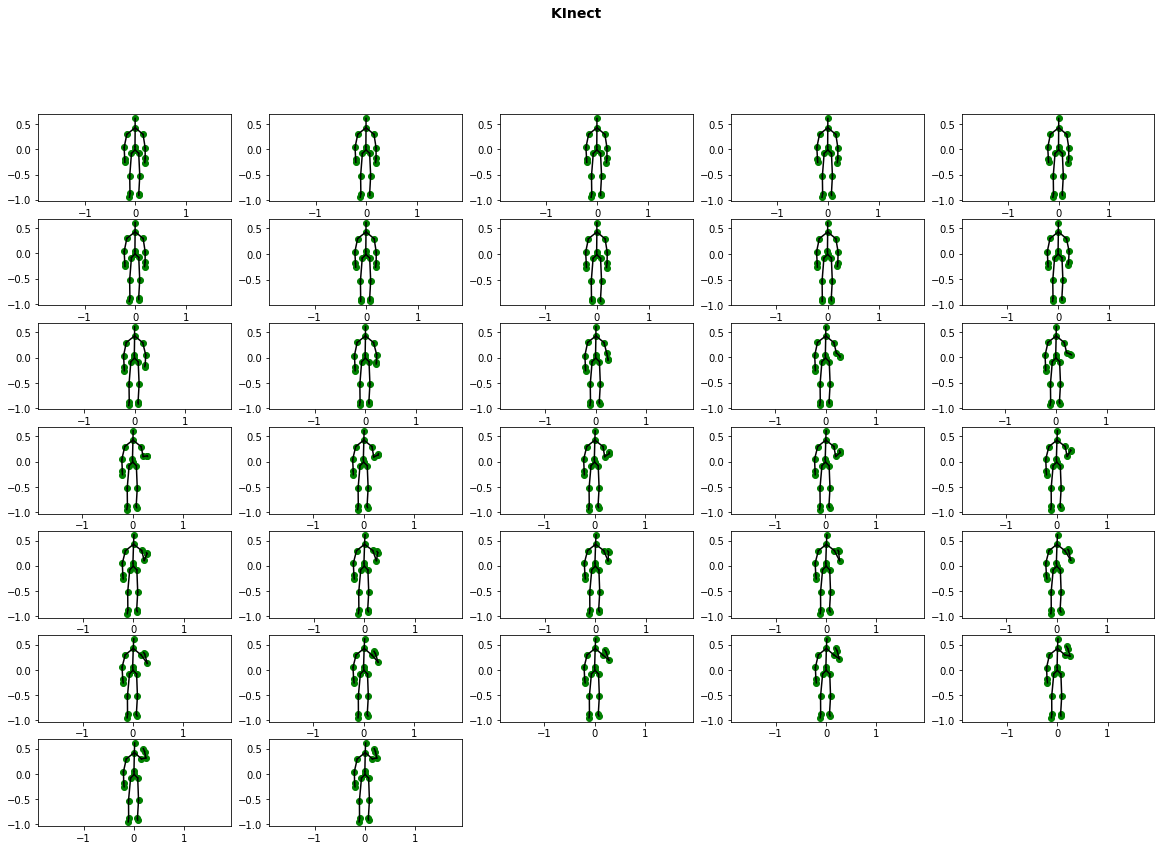

In [239]:

i = 190
a = Train1['pose'][190].reshape(-1,20,3)
print(a.shape)
print(Train1['label'][i])
fig = plt.figure(figsize=(20, 15))
fig.suptitle('KInect ', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 8
columns = 5 

for i in range(32):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(a[i], joint_orders_kinect) 


In [25]:
a = Test['pose'][270].reshape(-1,20,3)
a.shape

(83, 20, 3)

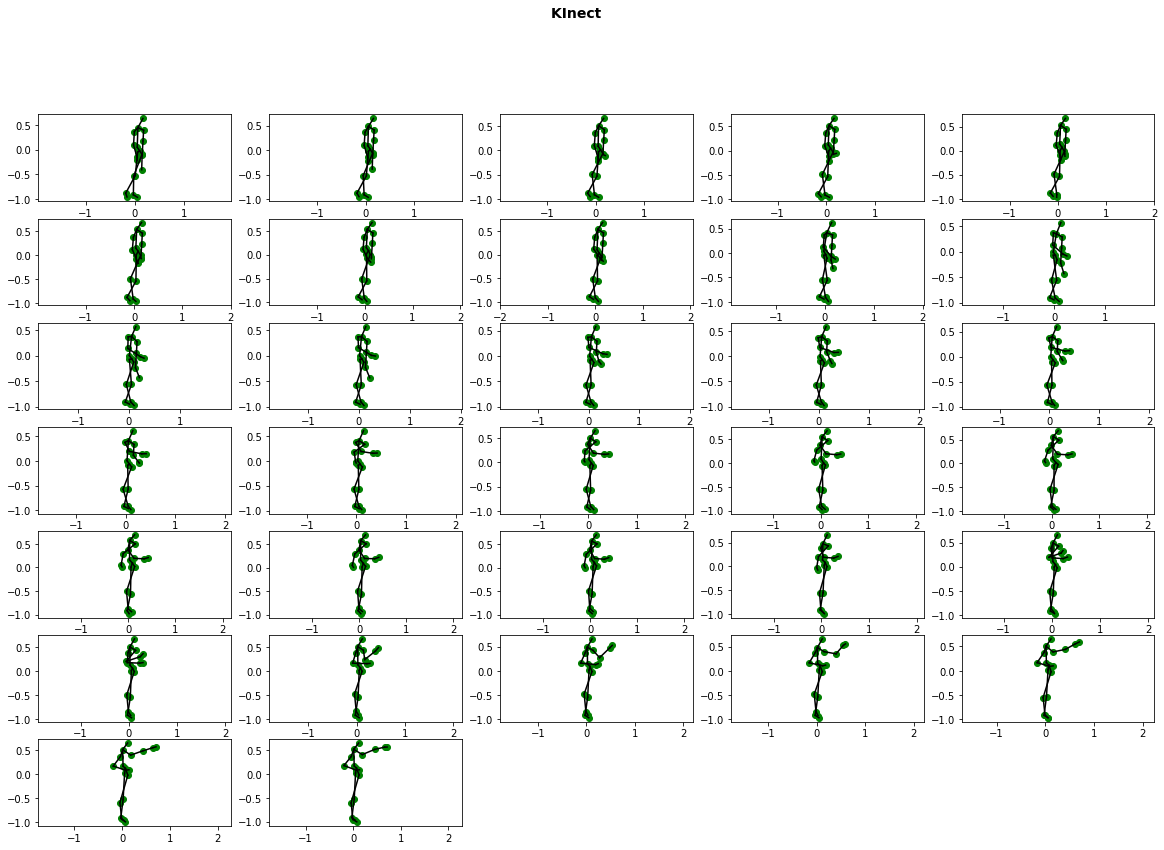

In [26]:
fig = plt.figure(figsize=(20, 15))
fig.suptitle('KInect ', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 8
columns = 5

for i in range(32):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(a[i], joint_orders_kinect) 

In [20]:
p1 = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
p1.shape

(32, 20, 3)

In [10]:
a.shape

(111, 20, 3)

In [4]:
import pickle
Test = pickle.load(open("/home/giang/Downloads/MICA_data/detector_data/win_test_detector.pkl", "rb"))
Train = pickle.load(open("/home/giang/Downloads/MICA_data/detector_data/win_train_detector.pkl", "rb"))

In [11]:
import pickle
Test = pickle.load(open("/home/giang/Downloads/Weight_Tien/guiTien/test-MICAfull.pkl", "rb"))
Train = pickle.load(open("/home/giang/Downloads/Weight_Tien/guiTien/train-MICAfull.pkl", "rb"))

In [136]:
win_train ={}
win_train['pose'] =[]
win_train['label'] =[]
win_test ={}
win_test['pose'] =[]
win_test['label'] =[]


In [1]:
count = 0
a = []
for index, data in enumerate(Train1['pose']):
    if data.shape[0] <31:
        count = count +1 
        a.append(index)
        
print(count)
print(a)

NameError: name 'Train1' is not defined

In [289]:
Train1['pose'][639].shape

(29, 60)

In [268]:
# Tạo dữ liệu action label 1 cho data train
# Duyệt tất cả data ain
for index, data in enumerate(Train1['label']):
    # nếu label = 0
    if data == 0:
        a = Train1['pose'][index]
        for i in range(2, a.shape[0]-31, 4 ):
            win_train['pose'].append(a[i:i+31])
            win_train['label'].append(0)
    else:
        a = Train1['pose'][index]
        

        if a.shape[0]<40:
        # Bỏ 6 frame đầu
            win_train['pose'].append(a[6:])
            win_train['label'].append(1)
    # Nếu số frame >40
        else:
        
            for i in range(6,a.shape[0]-31,4):
                win_train['pose'].append(a[j:j+31])  
                win_train['label'].append(1)
                 

                 

In [271]:
print(len(win_train['label']))
print(len(win_train['pose']))

10635
10635


In [272]:
# Tạo dữ liệu action label 1 cho data train
# Duyệt tất cả data ain
for index, data in enumerate(Test1['label']):
    # nếu label = 0
    if data == 0:
        a = Test1['pose'][index]
        for i in range(2, a.shape[0]-31, 4 ):
            win_test['pose'].append(a[i:i+31])
            win_test['label'].append(0)
    else:
        a = Test1['pose'][index]
        

        if a.shape[0]<40:
        # Bỏ 6 frame đầu
            win_test['pose'].append(a[6:])
            win_test['label'].append(1)
    # Nếu số frame >40
        else:
        
            for i in range(6,a.shape[0]-31,4):
                win_test['pose'].append(a[j:j+31])  
                win_test['label'].append(1)
                 


In [273]:
print(len(win_test['label']))
print(len(win_test['pose']))

4886
4886


In [53]:
path = '/home/giang/Downloads/MICA_data/window_classifier/'
train = pickle.dump(act_train, open(path + "win_train_clf.pkl","wb"))
test = pickle.dump(act_test, open(path + "win_test_clf.pkl","wb"))

In [28]:
for i in Test1['pose']:
    # Nếu số frame < 40 
    if i.shape[0]<40:
        # Bỏ 6 frame đầu
        win_test['pose'].append(i[6:])
        win_test['label'].append(1)
    # Nếu số frame >40
    else:
        
        for j in range(6,i.shape[0]-33,16):
            win_test['pose'].append(i[j:j+33])  
            win_test['label'].append(1)
                 
                 
            if ( 6 < i.shape[0]- j -33  < 17):
                
                 win_test['pose'].append(i[-35:-3])
    
                 win_test['label'].append(1)

In [55]:
print(len(win_train['pose']))
print(len(win_train['label']))
print(len(win_test['pose']))
print(len(win_test['label']))


7007
7007
7083
7083


In [130]:
no_train ={}
no_train['pose'] =[]
no_train['label'] =[]
no_test ={}
no_test['pose'] =[]
no_test['label'] =[]


In [124]:
set(act_train['label'])

{1}

In [132]:
set(Test1['label'])

{0}

In [133]:

for i in range(len(Train1['pose'])):
   

        
        
            for j in range(2,Train1['pose'][i].shape[0]-31,2):
                no_train['pose'].append(Train1['pose'][i][j:j+31])  
                no_train['label'].append(0)
                 

    


In [134]:
for i in range(len(Test1['pose'])):


        
        
            for j in range(2,Test1['pose'][i].shape[0]-31,2):
                no_test['pose'].append(Test1['pose'][i][j:j+31])  
                no_test['label'].append(0)
                 

In [135]:
print(len(no_train['pose']))
print(len(no_train['label']))
print(len(no_test['pose']))
print(len(no_test['label']))

4544
4544
2378
2378


In [25]:
set(no_train['label'])

{0}

In [69]:
for j in range(10,30-16,8):
    print(j)

10


In [36]:
list_no_test = []
for i in range(len(Test['pose'])):
    if (Test['label'][i]==0):
        list_no_test.append(i)
        
        if Test['pose'][i].shape[0] < 40:
        # Bỏ 6 frame đầu
            no_test['pose'].append(Test['pose'][i][6:])
            no_test['label'].append(0)
    # Nếu số frame >40
        else:
        
            for j in range(6,Test['pose'][i].shape[0]-33,16):
                no_test['pose'].append(Test['pose'][i][j:j+33])  
                no_test['label'].append(0)
                 
                 
                if ( 6 < Test['pose'][i].shape[0]- j -33  < 17):
                
                     no_test['pose'].append(Test['pose'][i][-35:-3])
    
                     no_test['label'].append(0)
    

In [37]:
print(len(no_train['pose']))
print(len(no_train['label']))
print(len(no_test['pose']))
print(len(no_test['label']))


762
762
183
183


In [137]:
print(len(act_train['pose']) + len(no_train['pose']))

13641


In [139]:
len(win_train['pose'])

0

In [141]:
for i in act_train['pose']:
    win_train['pose'].append(i)
    win_train['label'].append(1)
for j in no_train['pose']:
    win_train['pose'].append(j)
    win_train['label'].append(0)
print(len(win_train['pose']))

13641


In [142]:
for i in act_test['pose']:
    win_test['pose'].append(i)
    win_test['label'].append(1)
for j in no_test['pose']:
    win_test['pose'].append(j)
    win_test['label'].append(0)
print(len(win_test['pose']))

7050


In [138]:
set(act_test['label'])

{1}

In [ ]:
for i in range

In [140]:
print(len(act_train['pose']) + len(no_train['pose']))


13641


In [36]:
print(len(act_test['pose']))

7756


In [143]:
path = '/home/giang/Downloads/MICA_data/detector_data_ver1/'
train = pickle.dump(win_train, open(path + "win_train_detector.pkl","wb"))
test = pickle.dump(win_test, open(path + "win_test_detector.pkl","wb"))

In [48]:
type(train)

NoneType

In [186]:
a = Train['pose'][162]


In [187]:
a.shape

(115, 60)

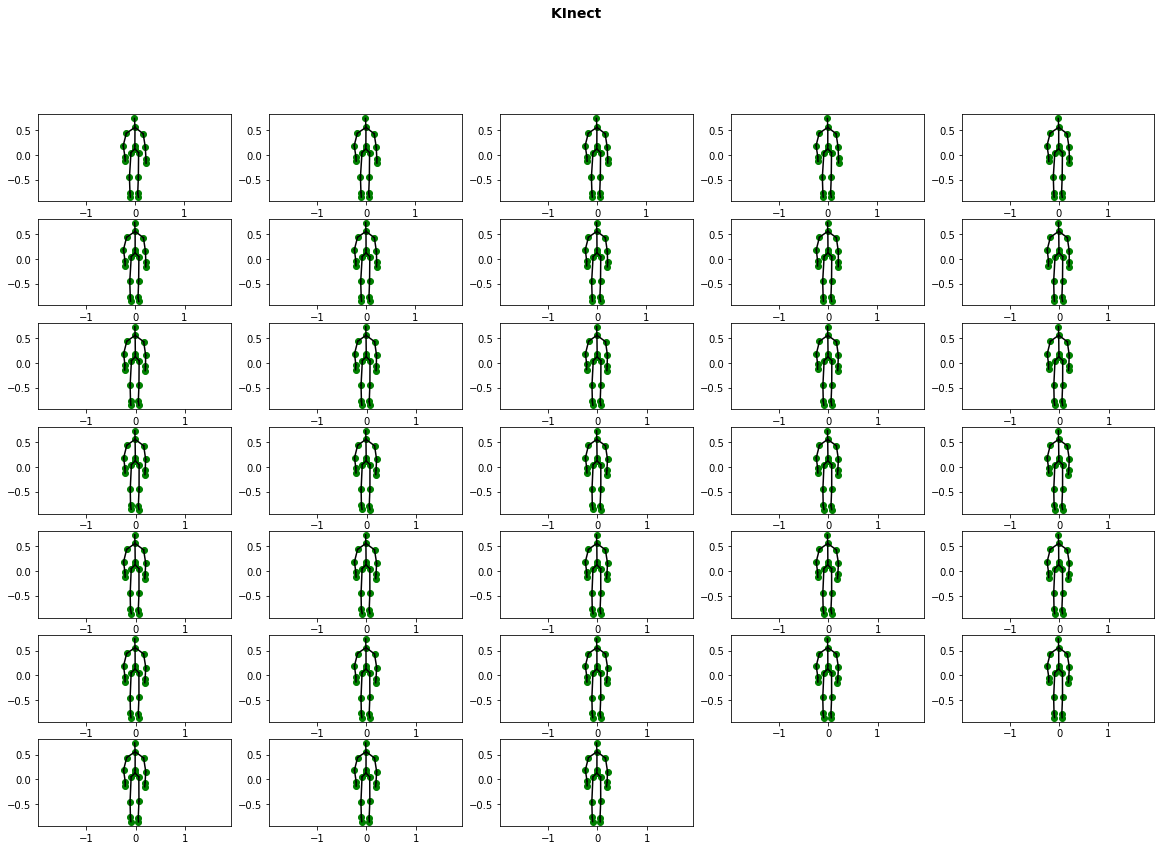

In [189]:

a = a.reshape(-1,20,3)
fig = plt.figure(figsize=(20, 15))
fig.suptitle('KInect ', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 8
columns = 5

for i in range(33):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(a[i+40], joint_orders_kinect) 

In [ ]:

fig = plt.figure(figsize=(20, 15))
fig.suptitle('KInect ', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 8
columns = 5

for i in range(33):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(a[i+40], joint_orders_kinect) 

In [148]:
print(55-33-6)

16


In [117]:
print(85-33-38)

14


In [130]:
len(window['pose'])

3573

In [80]:
a = Train1['pose'][20]

In [119]:
a = window['pose'][0]
b= window['pose'][1]
c = window['pose'][4]


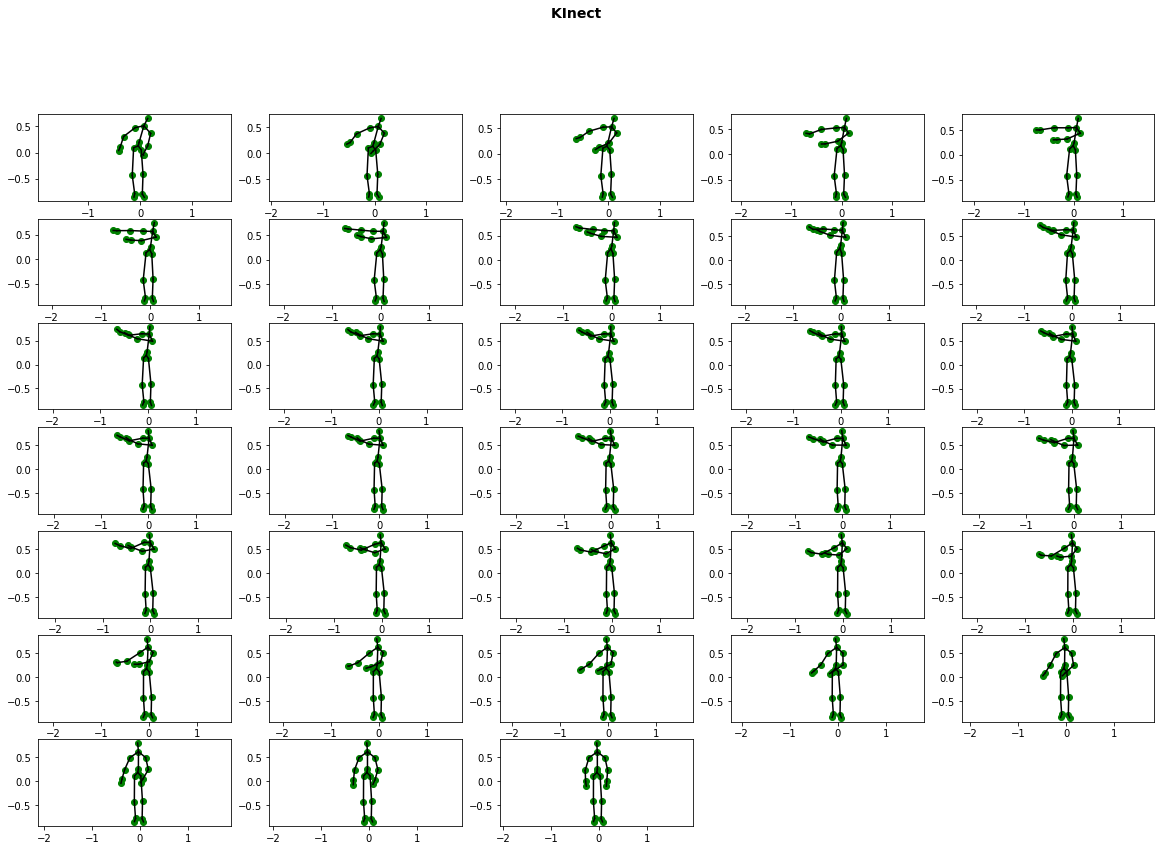

In [121]:

c = c.reshape(-1,20,3)
fig = plt.figure(figsize=(20, 15))
fig.suptitle('KInect ', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 8
columns = 5

for i in range(33):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(c[i], joint_orders_kinect) 
  

In [85]:
b = window['pose'][1]

In [88]:
b = b.reshape(-1,20,3)
b.shape

(33, 20, 3)

In [ ]:
for i in 

In [18]:
print(a)

14


In [10]:
len(Test['pose'])

341

In [56]:
def data_generator_test(T,C):
    p = np.copy(T).reshape(-1,20,3)
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = norm_train(p)
    M = get_CG(p,C)
    f1 = np.expand_dims(M, axis = 0)
    f2 = np.expand_dims(p, axis = 0)

    return f1,f2,p

In [20]:
a = Train['pose'][0]
a1,a2, a3= data_generator_test(a,C)
a3.shape

(32, 20, 3)

In [15]:
a2.shape

(1, 32, 20, 3)

In [17]:
# Check weight 21 trên tập test
for i in range(50):
    print(Test['label'][i])
    print( np.argmax(DD_Net.predict(data_generator_test(Test['pose'][i],C))) )
    print('=============================')


    

6
6
8
8
0
0
16
16
20
20
13
13
3
3
18
18
19
19
13
13
6
6
19
19
12
12
12
12
0
0
6
3
6
6
8
8
16
16
11
11
4
4
20
20
1
1
10
10
0
0
20
20
10
10
0
0
8
8
0
0
16
16
8
8
14
14
14
14
11
11
8
8
14
14
5
5
7
7
0
0
14
14
3
3
7
7
8
8
0
0
16
16
7
7
3
3
20
20
8
8


In [100]:
a1 = np.expand_dims(a1, axis=0)

In [83]:
a = np.expand_dims(X_test_0[1], axis = 0)
b = np.expand_dims(X_test_1[1], axis = 0)

In [84]:
a.shape

(1, 32, 190)

In [85]:
Y_pred = DD_Net.predict([a,b])
np.argmax(Y_pred)

7

In [86]:
Y_pred.shape

(1, 21)

In [ ]:
def data_generator_rt(T,C):
    X_0 = []
    X_1 = []
    T = np.expand_dims(T, axis = 0)
    for i in tqdm(range(len(T))): 
        p = np.copy(T[i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        p = norm_train(p)
        M = get_CG(p,C)
        X_0.append(M)
        X_1.append(p)
    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1)
    return X_0,X_1

In [11]:
# Đầu vào là chuỗi khung xương dạng np.ndarray   (số frame x 20 x3 )
# Đầu ra là double feaure đưa vào mô hình predict

def data_generator_test(T,C):
    p = np.copy(T).reshape(-1,20,3)
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = norm_train(p)
    M = get_CG(p,C)
    f1 = np.expand_dims(M, axis = 0)
    f2 = np.expand_dims(p, axis = 0)

    return f1,f2
    
    
    

In [12]:
for i in range(50):
    print(Test1['label'][i]) # label gốc
    res = DD_Net.predict(data_generator_test(Test1['pose'][i],C))[0]
    print(np.argmax(res)) # label predict
    print(res)
    print('==============')

1
0
[9.9180639e-01 2.3827801e-04 1.3551809e-04 8.9614528e-05 2.6467242e-04
 3.1048752e-04 3.9431319e-04 5.2354089e-04 8.9593045e-04 2.1286789e-04
 1.4750737e-04 2.5877563e-04 2.9394319e-04 1.4980412e-04 7.7349722e-04
 3.8497857e-04 1.9483380e-04 1.0060419e-03 1.1547871e-04 1.8033977e-03]
1
0
[9.9656278e-01 9.5619020e-05 5.1519910e-05 4.1428259e-05 1.0109384e-04
 1.2852131e-04 1.7027248e-04 2.2513040e-04 2.4754499e-04 6.7101457e-05
 5.0564831e-05 1.2232577e-04 1.2600256e-04 6.9019210e-05 3.1896695e-04
 2.1065446e-04 6.7869769e-05 4.0831076e-04 6.0258215e-05 8.7506912e-04]
1
0
[9.94946897e-01 1.19157470e-04 4.72232241e-05 6.07287075e-05
 1.36227260e-04 3.20599269e-04 1.82216783e-04 2.75616330e-04
 5.97057748e-04 1.23901918e-04 9.72249254e-05 1.09045126e-04
 1.88542865e-04 8.95854027e-05 4.41072363e-04 2.23148119e-04
 1.06553030e-04 3.78009601e-04 4.50434891e-05 1.51223829e-03]
1
0
[9.9022031e-01 2.6200179e-04 1.2695632e-04 1.3276744e-04 3.1081453e-04
 5.0528976e-04 4.1273856e-04 4.931478

2
[2.0356119e-05 5.4520883e-06 9.9578297e-01 1.7625600e-04 7.0046372e-05
 1.1685139e-04 4.6733380e-04 2.1186433e-04 1.1312084e-03 4.6389778e-06
 9.1938302e-05 6.9907226e-05 6.2128471e-05 2.9943182e-04 9.9313875e-05
 4.0316980e-04 2.8496661e-04 1.2019953e-05 6.6130370e-04 2.8709357e-05]
3
2
[2.5253190e-04 6.6339133e-05 9.6809769e-01 1.4730612e-03 1.0489841e-03
 8.6712576e-03 3.6546825e-03 7.1658322e-04 4.3733856e-03 8.5361498e-05
 5.6423148e-04 4.2702269e-04 4.9627537e-04 1.2387773e-03 4.1786450e-04
 1.7003780e-03 4.6006017e-03 1.3900299e-04 1.6619363e-03 3.1400422e-04]
3
2
[5.63229041e-05 1.55263497e-05 9.92709398e-01 9.15939745e-05
 4.00133198e-04 1.97886387e-04 7.10439461e-04 4.26250859e-04
 2.20964430e-03 6.20912715e-06 1.92474196e-04 1.06706604e-04
 1.13242153e-04 4.07758664e-04 1.78389193e-04 5.41730085e-04
 5.97638369e-04 2.44900766e-05 9.66684194e-04 4.74907356e-05]
3
2
[1.9467185e-04 4.4803099e-05 9.7581077e-01 2.3754775e-03 5.1718834e-04
 1.1578328e-03 1.8233316e-03 1.5293279e

In [22]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [23]:
mp_pose = mp.solutions.pose # pose model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [24]:
def mediapipe_detection(image, model):


    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False               # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [25]:
def draw_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS) # Draw pose connections
   

In [26]:
def draw_styled_landmarks(image, results):

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 

In [27]:
def extract_keypoints(results):
    if results.pose_world_landmarks:
        pose = np.array([[res.x, res.y, res.z] for res in results.pose_world_landmarks.landmark]) 

    return pose


In [28]:
labels = [ 'No Action', 'High Arm Wave', 'Horizontal Arm Wave','Hammer','Hand Catch','Forward Punch','High Throw','Draw X','Draw Tick','Draw Circle','Hand Clap','Two-hand wave','Side boxing','Bend','forward kick','Side Kick','Jogging','Tennis Swing','Tennis Serve','Golf Swing','Pick-up and Throw']

In [29]:
colors =[]
a = (0,127,255)
for i in range(21):
    colors.append(a)
    

In [30]:
def prob_viz(res, labels, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res[0]):
        cv2.rectangle(output_frame, (0,25+num*20), (int(prob*150), 45+num*20), colors[num], -1)
        
       
        cv2.putText(output_frame, labels[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [31]:
len(labels)

21

In [32]:
window_size = 32
sequence = []
sentence = []
predictions = []
threshold = 0.5
label = None
prev_frame_time = 0

global res
cap = cv2.VideoCapture('/home/giang/Downloads/MICA_data/MICA-Action2020/Subject03Viet/Kinect_1/color.avi')
# Set mediapipe model 
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.rotate(frame, cv2.ROTATE_180) 

        # Make detections
        image, results = mediapipe_detection(frame, pose)
        
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        # 33x3
        keypoints = extract_keypoints(results)
        # Chuyển thành list
        #keypoints = keypoints.tolist()

        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time
        
        if len(sequence) < window_size:
            # sequence là list mảng numpy 33x3 
            sequence.append(keypoints)

        else:
            # 
            # chuyển sang biến mới np array
            sequence1 = [mp2kinect(sequence[i]) for i in range(len(sequence))]
            sequence1 = np.array(sequence1)
            res = DD_Net.predict(data_generator_test(sequence1,C))
            
            idx = np.argmax(res)
            label =  labels[idx]
            
            
            
            # bug here 
            sequence.pop(0)
            sequence.append(keypoints)

            
        fps = str(fps)
        fps = fps[0:4]
        

            

        image = cv2.rotate(image, cv2.ROTATE_180)
        image = prob_viz(res, labels, image, colors)
        

                         
        #image = cv2.flip(image, 1)
        if label is not None:
            cv2.putText(image, 'Class: {}'.format(label),
               (int(width-400), height-50), cv2.FONT_HERSHEY_COMPLEX, 0.9, (102, 255, 255), 2)
        cv2.putText(image, 'FPS: {}'.format(fps), (7, 70), cv2.FONT_HERSHEY_SIMPLEX, 3, (100, 255, 0), 3, cv2.LINE_AA) 
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'res' is not defined

In [75]:
    cv2.destroyAllWindows()

In [39]:
res1 = res

In [38]:
res[np.argmax(res)]

array([9.4998556e-01, 4.6670754e-03, 4.3781861e-03, 3.2834080e-03,
       6.2018773e-03, 1.7080922e-03, 2.7907155e-03, 7.9230370e-04,
       2.3509820e-03, 2.3052550e-03, 1.0967785e-03, 7.7030691e-04,
       2.2393267e-03, 2.2178800e-03, 1.4943787e-03, 1.2084093e-03,
       3.3809922e-03, 1.8599539e-03, 2.6369668e-03, 2.4172035e-03,
       2.2142343e-03], dtype=float32)

In [35]:
colors = [(0,0,255), (0,127,255), (0,255,255), (0,255,0), (255,0,0), (95,43,46), (255,0,139)]

In [61]:
img = 255 * np.zeros((480, 480, 3), dtype=np.uint8)
for num, prob in enumerate(res[0]):
    if res1[0][0] > 0.7:
        cv2.rectangle(img, (0,25+num*20), (prob*150 , 45+num*20), colors[num%7], -1)
        cv2.putText(img, labels[0] + ': ' + str(int(res[np.argmax(res)] * 100)) + '%', (0, 465), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [67]:
colors[0%7]

(0, 0, 255)

In [55]:
res1[0]

array([9.4998556e-01, 4.6670754e-03, 4.3781861e-03, 3.2834080e-03,
       6.2018773e-03, 1.7080922e-03, 2.7907155e-03, 7.9230370e-04,
       2.3509820e-03, 2.3052550e-03, 1.0967785e-03, 7.7030691e-04,
       2.2393267e-03, 2.2178800e-03, 1.4943787e-03, 1.2084093e-03,
       3.3809922e-03, 1.8599539e-03, 2.6369668e-03, 2.4172035e-03,
       2.2142343e-03], dtype=float32)

In [59]:
res[0]

array([9.4998556e-01, 4.6670754e-03, 4.3781861e-03, 3.2834080e-03,
       6.2018773e-03, 1.7080922e-03, 2.7907155e-03, 7.9230370e-04,
       2.3509820e-03, 2.3052550e-03, 1.0967785e-03, 7.7030691e-04,
       2.2393267e-03, 2.2178800e-03, 1.4943787e-03, 1.2084093e-03,
       3.3809922e-03, 1.8599539e-03, 2.6369668e-03, 2.4172035e-03,
       2.2142343e-03], dtype=float32)

In [ ]:
colors[2]

In [45]:
res1[0][0]

0.94998556

In [42]:
np.argmax(res)

0

In [41]:
res1[np.argmax(res)]

array([9.4998556e-01, 4.6670754e-03, 4.3781861e-03, 3.2834080e-03,
       6.2018773e-03, 1.7080922e-03, 2.7907155e-03, 7.9230370e-04,
       2.3509820e-03, 2.3052550e-03, 1.0967785e-03, 7.7030691e-04,
       2.2393267e-03, 2.2178800e-03, 1.4943787e-03, 1.2084093e-03,
       3.3809922e-03, 1.8599539e-03, 2.6369668e-03, 2.4172035e-03,
       2.2142343e-03], dtype=float32)

In [43]:
 cv2.imshow('OpenCV Feed', image)

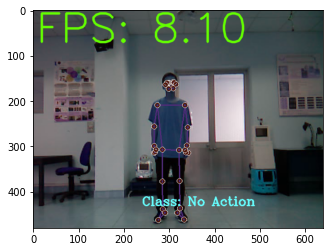

In [45]:
plt.imshow(image)

In [42]:
res

array([[9.4773757e-01, 4.9023530e-03, 4.5907455e-03, 3.3040382e-03,
        6.5375273e-03, 1.8171682e-03, 2.9134422e-03, 8.2178001e-04,
        2.4511602e-03, 2.4209127e-03, 1.1478309e-03, 8.0563908e-04,
        2.3449101e-03, 2.3111284e-03, 1.5656614e-03, 1.2638253e-03,
        3.5737983e-03, 1.9561625e-03, 2.7381070e-03, 2.5048645e-03,
        2.2913027e-03]], dtype=float32)

In [33]:
cv2.destroyAllWindows()

In [21]:
len(sequence)

22

In [44]:
sequence1 = [mp2kinect(sequence[i]) for i in range(len(sequence))]
sequence1 = np.array(sequence1)
sequence1.shape

(30, 20, 3)

In [24]:
a = DD_Net.predict(data_generator_test(sequence1,C))

In [25]:
a

array([[0.1551634 , 0.00214059, 0.00294304, 0.00323793, 0.01023873,
        0.00570886, 0.00089765, 0.00422246, 0.00178462, 0.00254369,
        0.00195162, 0.00528971, 0.00150352, 0.00294757, 0.01712611,
        0.76213473, 0.00177135, 0.0074697 , 0.0065205 , 0.00440428]],
      dtype=float32)

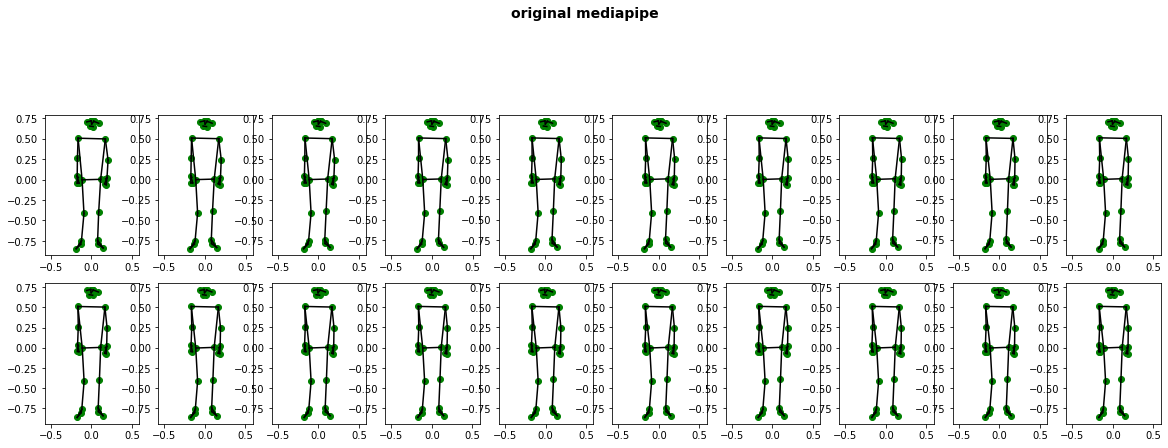

In [22]:
fig = plt.figure(figsize=(20, 15))
fig.suptitle('original mediapipe', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 5
columns = 10

for i in range(20):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(sequence[i], joint_orders_mp) 

In [35]:
a3.shape

(32, 20, 3)

In [36]:
a3[1].shape

(20, 3)

In [79]:
a = Train['pose'][0]
a = a[0:16]
print(a.shape)
a1,a2,a3 = data_generator_test(a,C)
print(a3.shape)

(16, 60)
(16, 20, 3)


In [75]:
a3.shape

(16, 20, 3)

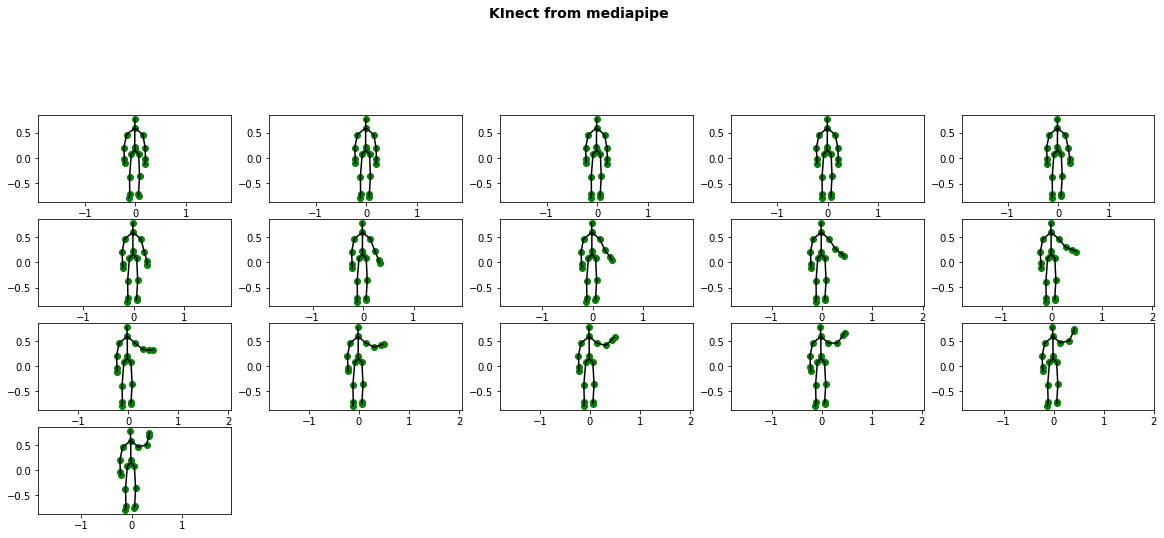

In [80]:
fig = plt.figure(figsize=(20, 15))
fig.suptitle('KInect from mediapipe', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 8
columns = 5

for i in range(16):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(a3[i], joint_orders_kinect) 
  

In [ ]:
a 

2
(68, 60)


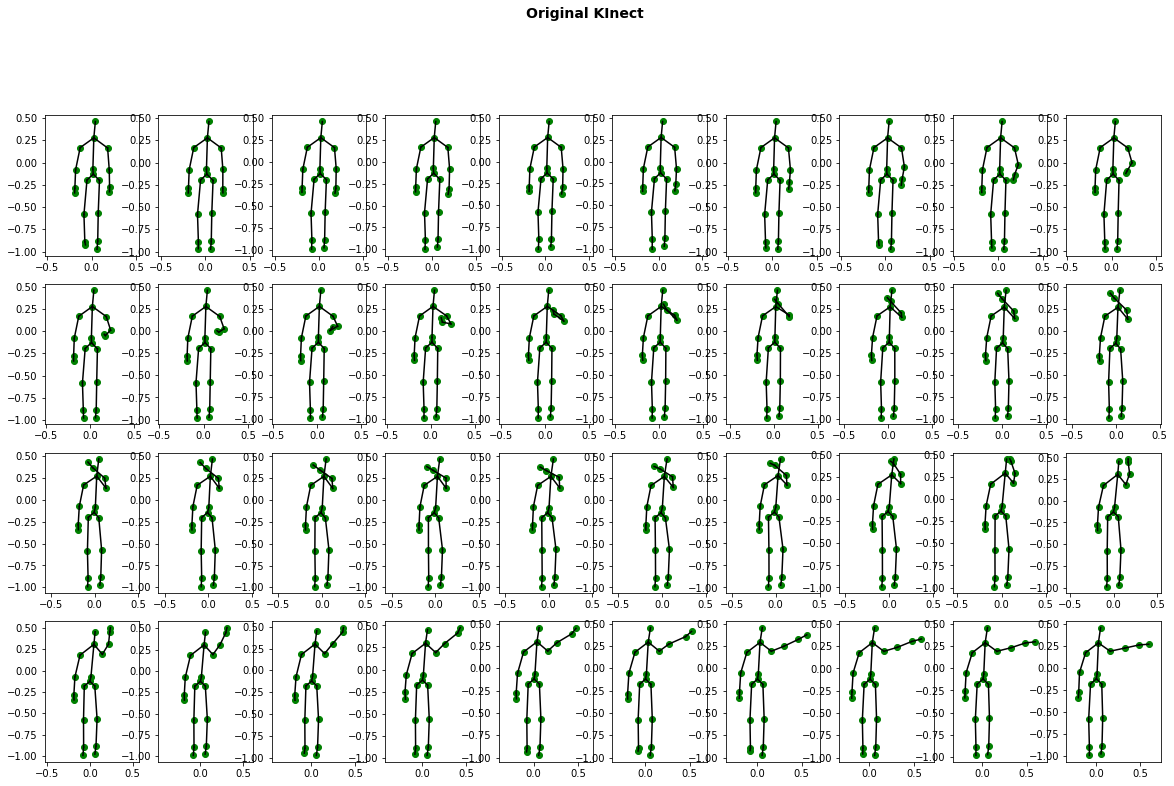

In [27]:
i = 20
a = Test1['pose'][i]
print(Test1['label'][i])
print(a.shape)
a = np.reshape(a,(-1,20,3))
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Original KInect', fontsize=14, fontweight='bold')
# setting values to rows and column variables
rows = 5
columns = 10

for i in range(40):
    
    fig.add_subplot(rows, columns, i+1)
    visualize(a[i+10], joint_orders_kinect) 